<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Early_fusion_Effnet_lesion_based_attention_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] =  dataset_images_location+'/'+df['Image name']+'.jpg'
df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,/content/drive/My Drive/IDRid/B. Disease Gradi...,2
256,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
290,/content/drive/My Drive/IDRid/B. Disease Gradi...,1
311,/content/drive/My Drive/IDRid/B. Disease Gradi...,0
389,/content/drive/My Drive/IDRid/B. Disease Gradi...,4


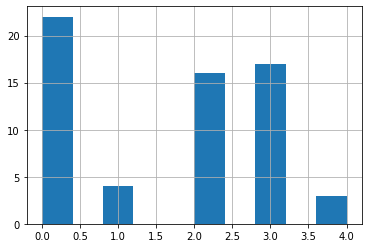

In [4]:
val_df['Retinopathy grade'].hist()

In [5]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


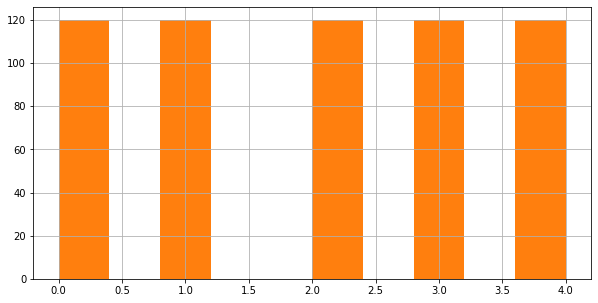

In [6]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [7]:
def crop_image_from_gray(img, tol=7):
    IMG_WIDTH=512
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            img = cv2.resize(img, (IMG_WIDTH, IMG_WIDTH))/255
        return img

In [8]:
train_df['Retinopathy grade']=train_df['Retinopathy grade'].astype('str')
val_df['Retinopathy grade'] =val_df['Retinopathy grade'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=512,512

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function= crop_image_from_gray
                                )
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE)
val_datagen = ImageDataGenerator(
                                  shear_range=0.0,
                                  zoom_range=[0.75,1],
                                  width_shift_range=1.1,
                                  height_shift_range=0.05,
                                  rotation_range=15,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                 preprocessing_function= crop_image_from_gray)

val_generator = val_datagen.flow_from_dataframe(  val_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE
                                                  )

Found 600 validated image filenames belonging to 5 classes.
Found 62 validated image filenames belonging to 5 classes.


## Read test_df


In [10]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_images_location+'/'+test_df['Image name']+'.jpg'
test_df_['Retinopathy grade'] = test_df['Retinopathy grade'].astype('str')
test_df = test_df_
print(test_df.head())

                                          Image name Retinopathy grade
0  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
1  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
2  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
3  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4
4  /content/drive/My Drive/IDRid/B. Disease Gradi...                 4


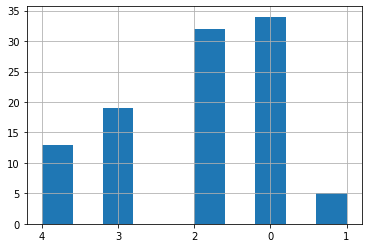

In [11]:
test_df['Retinopathy grade'].hist()

In [12]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = imread( image_name);
    img=crop_image_from_gray(img)
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32')/ np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)
enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(test_labels)
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape)

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [13]:
test_datagen = ImageDataGenerator(
                          shear_range=0.0,
                          zoom_range=[0.75,1],
                          width_shift_range=1.1,
                          height_shift_range=0.05,
                          rotation_range=15,
                          fill_mode='nearest',
                          horizontal_flip=True,
                          vertical_flip=True,
                          preprocessing_function= crop_image_from_gray)

test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=4
                                                  )

Found 103 validated image filenames belonging to 5 classes.


In [ ]:
"""from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)"""

'from sklearn.utils import shuffle\ntrain_images, train_labels = shuffle(train_images, train_labels, random_state = 1)\n# If train and test are from respective sets\nprint("train x size ",train_images.shape)\nprint("train y size ",train_labels.shape)\nprint("test x size ",test_images.shape)\nprint("test y size ",test_labels.shape)\nprint("val x size ",val_images.shape)\nprint("val y size ",val_labels.shape)'

1.0


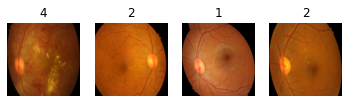

In [14]:
"""red colour indicates the imahges are read in RGB mode like matplotlib imread, and our segmentaion models were also
trained in rgb mode"""
for i,(img,lbl) in enumerate(train_generator):
  print(np.max(img))
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

1.0 (4, 512, 512, 3)


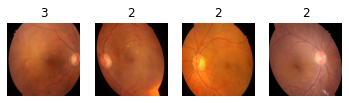

In [15]:
for i,(img,lbl) in enumerate(val_generator):
  print(np.max(img),img.shape)
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

1.0 (4, 512, 512, 3)


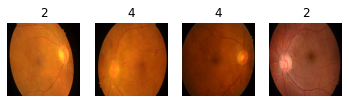

In [16]:
for i,(img,lbl) in enumerate(test_generator):
  print(np.max(img),img.shape)
  for j in range(4):
    ax=plt.subplot(1,4,j+1)  
    plt.imshow(img[j]/np.max(img))
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

In [17]:
from keras.models import Sequential
#from tensorflow.keras.applications import EfficientNetB0,EfficientNetB4
#from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [18]:
from tensorflow.keras.models import model_from_json
def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [19]:
def build_model(num_classes,input_size):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    IMG_SIZE=input_size
    NUM_CLASSES=num_classes
    # define inputs
    input_0 = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #input_1 = tf.keras.layers.experimental.preprocessing.Resizing(512,512,  name='resize_input')(input_0)
    base_model=load_seg_model('model_eff4_progr_resize(512*512)')
    feature_ext_model=load_seg_model('model_eff4_progr_resize(512*512)')
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE_1")
    # Freeze the pretrained weights
    base_model.trainable = True
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False

    #name
    base_model._name ='classification_model'
    ex_model._name   ='model_ex'
    ma_model._name   ='model_ma'
    se_model._name   ='model_se'
    he_model._name   ='model_he'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)
    intermediate_layer_model = Model(inputs=feature_ext_model.input,
                                 outputs=feature_ext_model.layers[-5].output)
    intermediate_layer_model._name='h_lvl_f_extractor'
    #intermediate_layer_model.trainable=False
    #print(base_model.layers[-5].name,f_high.shape)
    
    #attention generation
    #concat lesions
    att=layers.Concatenate(name='concat_lesion')([les_ex,les_se,les_ma,les_he])
    
    #generate features from att
    W_g=keras.layers.Conv2D(8, kernel_size=1, padding='same', strides=1,name='Wg_1')(att)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    W_g = Activation('relu')(W_g)
    W_g=keras.layers.Conv2D(16, kernel_size=1, padding='same', strides=1,name='Wg_2')(W_g)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    #input image
    W_x=keras.layers.Conv2D(8, kernel_size=3, padding='same', strides=1,name='Wx_1')(input_0)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    W_x = Activation('relu')(W_x)
    W_x=keras.layers.Conv2D(16, kernel_size=3, padding='same', strides=1,name='Wx_2')(W_x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to low level attention map
    att=layers.Add(name='additive_enhance_layer')([W_x,W_g])
    att=tf.keras.activations.relu(att, alpha=0.0, max_value=None, threshold=0)
    #att=keras.layers.Conv2D(8, kernel_size=1, padding='same', strides=1)(att)
    #att=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))
    
    #high level attention
    #f_high=intermediate_layer_model(input_0*255)
    #f_high=tf.keras.layers.Reshape((1,1,-1), input_shape=(-1,))(f_high)
    #f_high=keras.layers.Conv2D(8, kernel_size=1, padding='same', strides=1)(f_high)
    #att   =tf.keras.layers.Multiply()([att,f_high])
    att   =keras.layers.Conv2D(3, kernel_size=1, padding='same', strides=1)(att)
    att   =tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(att))

    #filter image
    x = tf.keras.layers.Multiply()([att,input_0*255])
    
    model_dense=Sequential()
    for i in range(1,5,1):
      print(base_model.layers[-5+i].name)
      model_dense.add(base_model.layers[-5+i])
    
    #x = base_model(x)
    x=intermediate_layer_model(x)
    x=model_dense(x)
    #predection_2
    #x = layers.GlobalAveragePooling2D()(x)
    # Rebuild top
    #top_dropout_rate=0.2
    #x = Flatten(name="flatten_2")(x)
    #x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    #x = Dense(256, activation="relu", name="last_dense_2")(x)
    #x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    #x = Dense(NUM_CLASSES, activation="softmax", name="pred_2")(x)
  
    # Compile
    model = tf.keras.Model(input_0, x, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [20]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
input_size=256*2
model=build_model(5,input_size)

model_eff4_progr_resize(512*512)  Model loaded and compiled
model_eff4_progr_resize(512*512)  Model loaded and compiled
model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled
dropout
dense_2
dropout_1
dense_3


In [21]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 19,944,649
Trainable params: 18,010,638
Non-trainable params: 1,934,011


In [25]:
#modelbase=model.get_layer('classification_model')
modelfeatext=model.get_layer('h_lvl_f_extractor')
#print(modelbase.trainable,modelfeatext.trainable)
print(modelfeatext.trainable)
#trainable_count = count_params(modelbase.trainable_weights)
#print(trainable_count)

True


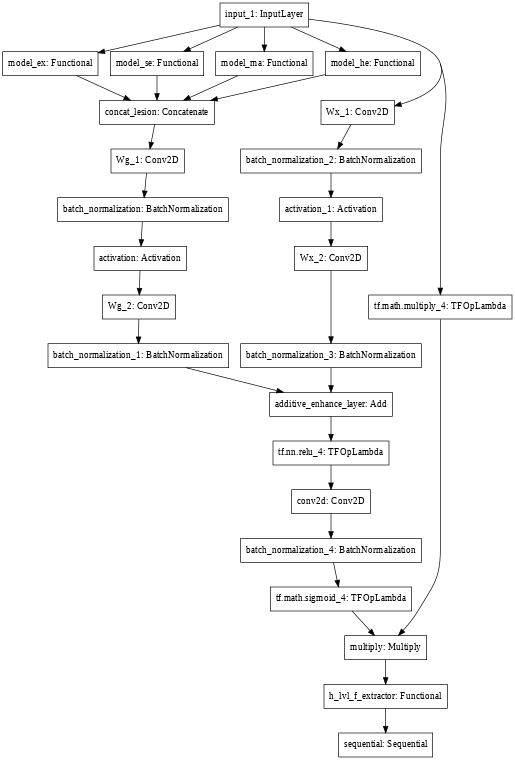

In [23]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

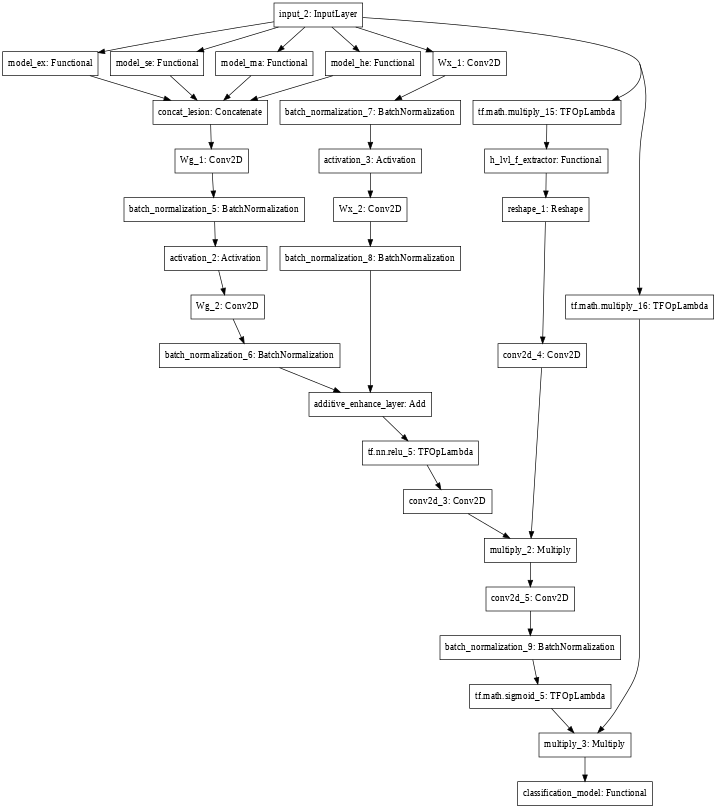

In [ ]:
## MODEL WITH HIGH LEVEL FEATURE EXTRACTION
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=48,
)

In [34]:
import keras.backend as K
from keras.callbacks import LambdaCallback
import math
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    #def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
    def find(self, gen, start_lr, end_lr, batch_size=64, epochs=1):
        #num_batches = epochs * x_train.shape[0] / batch_size
        num_batches=len(gen)
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        #self.model.fit(x_train, y_train,
        #                batch_size=batch_size, epochs=epochs,
        #                callbacks=[callback])
        self.model.fit( gen,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

Epoch 1/4
150/150 [==============================] - 307s 2s/step - loss: 1.0957 - accuracy: 0.5960
Epoch 2/4
150/150 [==============================] - 133s 884ms/step - loss: 304.3157 - accuracy: 0.2395


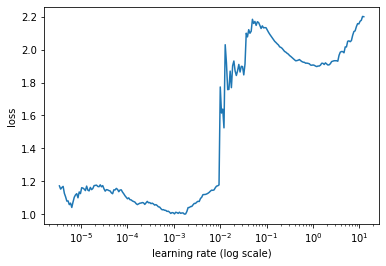

In [35]:
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1e-2, batch_size=4, epochs=4)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [36]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(5,input_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',  
                        min_delta=0.01)
hist=model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =20, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

model_eff4_progr_resize(512*512)  Model loaded and compiled
model_eff4_progr_resize(512*512)  Model loaded and compiled
model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled
dropout
dense_2
dropout_1
dense_3
Epoch 1/20
150/150 [==============================] - 232s 1s/step - loss: 1.4975 - accuracy: 0.4830 - val_loss: 1.6032 - val_accuracy: 0.2097
Epoch 2/20
150/150 [==============================] - 177s 1s/step - loss: 1.2663 - accuracy: 0.4400 - val_loss: 1.2483 - val_accuracy: 0.4516
Epoch 3/20
150/150 [==============================] - 179s 1s/step - loss: 1.1553 - accuracy: 0.5412 - val_loss: 0.9659 - val_accuracy: 0.6290
Epoch 4/20
150/150 [==============================] - 179s 1s/step - loss: 1.0890 - accuracy: 0.5539 - val_loss: 1.2561 - val_accuracy: 0.5000
Epoch 5/20
150/150 [==============================] - 179s 1s/step - loss: 0.9205 - accuracy: 0.5849 - val_loss: 1.6857 - val_ac

In [71]:
model.fit(train_generator,steps_per_epoch=len(train_generator) , 
               epochs =5, callbacks = [es,rlr],validation_data=val_generator,validation_steps=len(val_generator));

Epoch 1/5
150/150 [==============================] - 176s 1s/step - loss: 0.1664 - accuracy: 0.9333 - val_loss: 1.2026 - val_accuracy: 0.6452
Epoch 2/5
150/150 [==============================] - 176s 1s/step - loss: 0.1445 - accuracy: 0.9567 - val_loss: 1.1537 - val_accuracy: 0.6290
Epoch 3/5
150/150 [==============================] - 176s 1s/step - loss: 0.1164 - accuracy: 0.9550 - val_loss: 1.1217 - val_accuracy: 0.6452
Epoch 4/5
150/150 [==============================] - 178s 1s/step - loss: 0.1378 - accuracy: 0.9450 - val_loss: 1.0049 - val_accuracy: 0.7419
Epoch 5/5
150/150 [==============================] - 177s 1s/step - loss: 0.0920 - accuracy: 0.9683 - val_loss: 1.1583 - val_accuracy: 0.7258


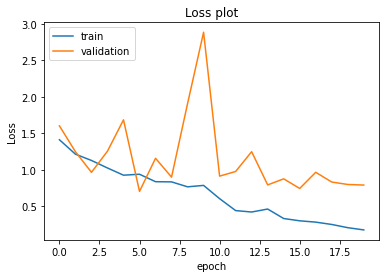

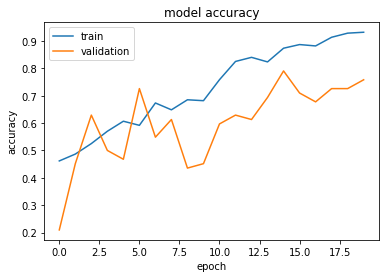

In [37]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [38]:
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

In [39]:
len(val_generator),len(val_generator)*4-2

(16, 62)

[[18  1  3  0  0]
 [ 2  1  1  0  0]
 [ 0  1 13  2  0]
 [ 0  0  3 14  0]
 [ 0  0  1  1  1]]
accuracy  0.7580645161290323  accuracy
quadratic kappa  0.8687058823529412


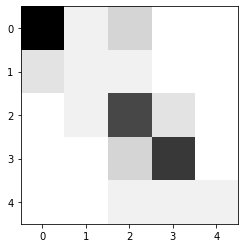

In [72]:
#after 5 more epcohs
pred_y_=np.zeros((len(val_generator)*4-2,5))
val_y_=np.zeros((len(val_generator)*4-2,5))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,:]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==15:
    break
pred_y_=pred_y_
cm=confusion_matrix(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print("accuracy ",accuracy_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_y_,axis=1)))

[[18  1  3  0  0]
 [ 2  1  1  0  0]
 [ 0  0 12  4  0]
 [ 0  0  3 13  1]
 [ 0  0  1  1  1]]
accuracy  0.7258064516129032  accuracy
quadratic kappa  0.8637672374602212


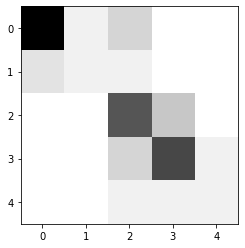

In [41]:
pred_y_=np.zeros((len(val_generator)*4-2,5))
val_y_=np.zeros((len(val_generator)*4-2,5))
for i,(img,lbl) in enumerate(val_generator):
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_y_[4*i:4*i+4,:]=lbl
  # run for loop len(val_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
  if i==15:
    break
pred_y_=pred_y_
cm=confusion_matrix(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print("accuracy ",accuracy_score(np.argmax(val_y_,axis=1),np.argmax(pred_y_,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(val_y_,axis=1)))

(array([22.,  0.,  4.,  0.,  0., 16.,  0., 17.,  0.,  3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

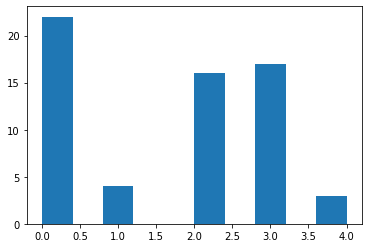

In [42]:
plt.hist(np.argmax(val_y_,axis=1))

## test accuracy

26
[[27  1  5  1  0]
 [ 5  0  0  0  0]
 [ 4  0 19  9  0]
 [ 1  0  3 14  1]
 [ 0  0  3  5  5]]
0.6310679611650486  accuracy
quadratic kappa  0.7724483283420884


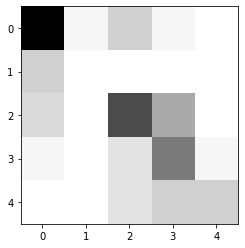

In [73]:
#after 5 more epcohs
pred_y_=np.zeros((103,5))
print(len(test_generator))
for i in range(len(test_generator)):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

26
[[28  3  3  0  0]
 [ 4  0  1  0  0]
 [ 3  2 19  8  0]
 [ 2  0  4 11  2]
 [ 0  0  3  3  7]]
0.6310679611650486  accuracy
quadratic kappa  0.7984052192823486


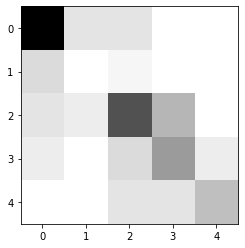

In [43]:
pred_y_=np.zeros((103,5))
print(len(test_generator))
for i in range(len(test_generator)):
  pred_y_[4*i:4*i+4]=model.predict(test_images[4*i:4*i+4])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

## acc with TTA

[[29  2  3  0  0]
 [ 2  0  3  0  0]
 [ 4  0 20  6  2]
 [ 1  0  6 12  0]
 [ 0  0  3  2  8]]
0.6699029126213593  accuracy
quadratic kappa  0.8047630619684083


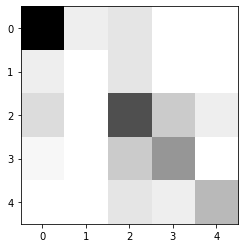

In [74]:
#after 5 more epcohs
pred_y_tta=np.zeros((len(test_generator)*4-1,5)) #len(test_generator)*4-1=103
test_y_=np.zeros((len(test_generator)*4-1,5))
score=0
qk=0
for k in range(10):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model.predict(img)
    test_y_[4*i:4*i+4,:]=lbl
    # run for loop len(test_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
    if i==25:
      break
  score_=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  qk_=quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1))
  cm_=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    qk   =qk_
    cm   =cm_
print(cm)
plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",qk)

[[24  3  7  0  0]
 [ 2  0  3  0  0]
 [ 2  3 18  7  2]
 [ 1  0  5 13  0]
 [ 0  0  2  3  8]]
0.6116504854368932  accuracy
quadratic kappa  0.7743673674933904


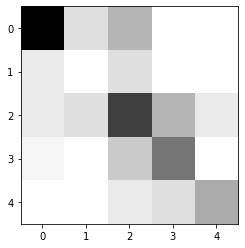

In [69]:
pred_y_tta=np.zeros((len(test_generator)*4-1,5)) #len(test_generator)*4-1=103
test_y_=np.zeros((len(test_generator)*4-1,5))
score=0
qk=0
for k in range(10):
  for i,(img,lbl) in enumerate(test_generator):
    pred_y_tta[4*i:4*i+4]=model.predict(img)
    test_y_[4*i:4*i+4,:]=lbl
    # run for loop len(test_generator) as it will cover all the images in test data i.e. last batch will be of 3 images
    if i==25:
      break
  score_=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  qk_=quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1))
  cm_=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
  if score_>score:
    score=score_
    qk   =qk_
    cm   =cm_
print(cm)
plt.imshow(cm, cmap='binary')
print(score," accuracy")
print("quadratic kappa ",qk)

(array([34.,  0.,  5.,  0.,  0., 32.,  0., 19.,  0., 13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

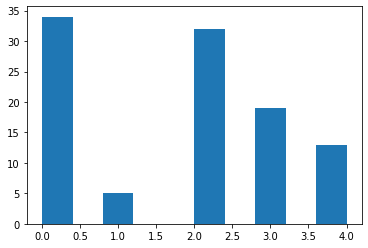

In [50]:
plt.hist(np.argmax(test_y_,axis=1))

## Get attention maps, filtered image


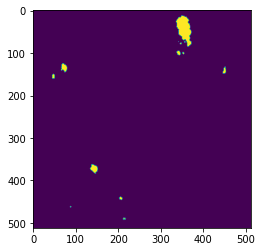

In [58]:
seg_model=model.get_layer(name='model_he') 
plt.imshow(np.squeeze(seg_model(test_images[9:10,:,:,:])[0],axis=2))

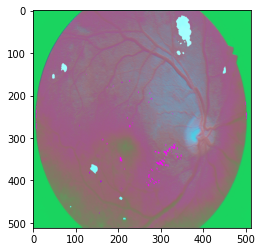

In [75]:
#after 5 more epcohs
layers_name=[]
index_att_layer=0
count=0
for i in model.layers:
  layers_name.append(i.name)
  if i.name=='tf.math.sigmoid_5':
    index_att_layer=count
  count+=1
att=Model(inputs=model.input,outputs=model.layers[index_att_layer].output) 
attention_map=att(test_images[9:10,:,:,:])
plt.imshow(attention_map[0,:,:,:])#/np.max(attention_map))

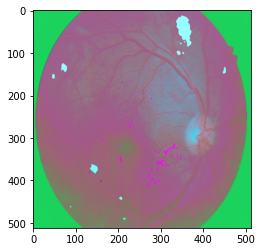

In [59]:
layers_name=[]
index_att_layer=0
count=0
for i in model.layers:
  layers_name.append(i.name)
  if i.name=='tf.math.sigmoid_5':
    index_att_layer=count
  count+=1
att=Model(inputs=model.input,outputs=model.layers[index_att_layer].output) 
attention_map=att(test_images[9:10,:,:,:])
plt.imshow(attention_map[0,:,:,:])#/np.max(attention_map))

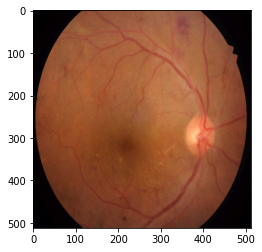

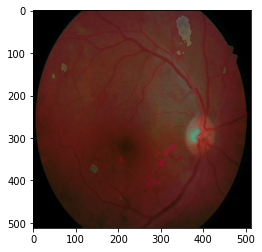

In [76]:
#after 5 more epcohs
filtered_image=Model(inputs=model.input,outputs=model.layers[-3].output) 
plt.imshow(test_images[9,:,:,:])
plt.show()
plt.imshow(filtered_image(test_images[9:10,:,:,:])[0,:,:,:]/255)
plt.show()

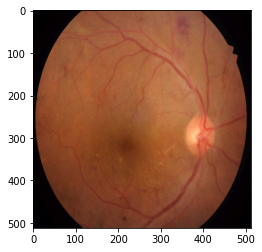

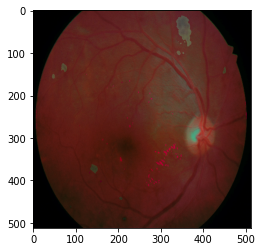

In [60]:
filtered_image=Model(inputs=model.input,outputs=model.layers[-3].output) 
plt.imshow(test_images[9,:,:,:])
plt.show()
plt.imshow(filtered_image(test_images[9:10,:,:,:])[0,:,:,:]/255)
plt.show()

## save model to disk

In [70]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/IDRid/Experimental models/eff4_early_fusion_lesion_based_atten_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/IDRid/Experimental models/eff4_early_fusion_lesion_based_atten_1.h5")
print("Saved model to disk")

Saved model to disk


## test on best validation model
Below this is not for this commit

In [ ]:
model_1=build_model(5,'EfficientNetB4')
model_1.load_weights("weights.07-0.71.hdf5") 

model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE_1  Model loaded and compiled


[[28  2  4  0  0]
 [ 5  0  0  0  0]
 [ 4  4 19  4  1]
 [ 2  0  6  9  2]
 [ 2  0  3  5  3]]
0.5728155339805825  acuracy
quadratic kappa  0.6789530971699981


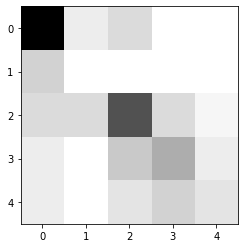

In [ ]:
pred_y_=np.zeros((test_labels.shape))
for i in range(18):
  pred_y_[6*i:6*i+6]=model_1.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_,axis=1),np.argmax(test_labels,axis=1)))

[[25  6  3  0  0]
 [ 3  1  1  0  0]
 [ 3  3 22  3  0]
 [ 2  0  7  7  3]
 [ 1  0  5  2  5]]
0.5882352941176471  accuracy
quadratic kappa  0.7169929850277458


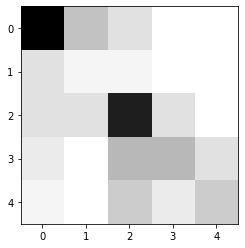

In [ ]:
for i,(img,lbl) in enumerate(x):
  #print(img.shape,lbl.shape)
  pred_y_tta[6*i:6*i+6]=model_1.predict(img)
  test_y_[6*i:6*i+6,:]=lbl
  if i==16:
    break
cm=confusion_matrix(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_y_,axis=1),np.argmax(pred_y_tta,axis=1))
print(score," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_tta,axis=1),np.argmax(test_y_,axis=1)))